In [110]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, model_from_json
from keras.layers import Dense, LSTM, Activation, Dropout
from dataloader import load_data, prepare_timeseries, convert_to_binary
from sklearn import metrics
import tensorflow as tf
import os
import sys
from collections import defaultdict
import pandas as pd
import seaborn

In [21]:
data = pd.read_csv('data/trade_data.csv')
target = data.WAP
data.drop('WAP', axis=1, inplace=True)

In [22]:
target.head()

0    8.97
1    9.02
2    9.15
3    9.30
4    9.26
Name: WAP, dtype: float64

In [23]:
data.head()

,DATE,OPEN,HIGH,LOW,CLOSE,LTTIME,VALUE,NUMTRADES
0,24.07.17,9.11,9.15,8.50,8.55,NaN,2325011000,37
1,25.07.17,9.09,9.10,8.81,8.81,NaN,3477388000,31
2,26.07.17,9.06,9.35,9.05,9.10,NaN,6537394000,36
3,27.07.17,9.17,9.40,9.17,9.25,NaN,3387899000,26
4,28.07.17,9.31,9.32,9.20,9.20,NaN,4659405000,31


Если я правильно понимаю, ты зануляешь.

In [25]:
data.fillna(0, inplace=True)

In [104]:
data.set_index('DATE', inplace=True)

## Добавим вторичные признаки

1)

In [118]:
sec_1 = pd.read_csv('data/fixed_percents_deposits.csv')

In [119]:
sec_1['MEAN_PERCENTS'] = sec_1.iloc[:, 1:5].mean(axis=1)

In [121]:
def date_parser(dataframe_col):
    for i, item in enumerate(dataframe_col):
        month, day, year = item.split('/')
        year = str(int(year) % 2000)
        if len(month) < 2:
            month = '0' + month 
        if len(day) < 2:
            day = '0' + day
        dataframe_col[i] = '.'.join([day, month, year])
        

In [122]:
date_parser(sec_1['Даты'])

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [123]:
sec_1 = sec_1[::-1]

In [124]:
sec_1.drop(columns=sec_1.columns[1:5], inplace=True)

In [125]:
sec_1.rename({'Дата' : 'DATE'}, axis=1, inplace=True)

In [126]:
sec_1.set_index('DATE', inplace=True)

In [139]:
sec_1.head()

,MEAN_PERCENTS
DATE,
24.07.17,8.0
25.07.17,8.0
26.07.17,8.0
27.07.17,8.0
28.07.17,8.0


2)

Для совместимости данных ставки за февраль были взяти такие же, как и за январь. (В идеале, конечно, можно и регрессию замутить, но зачем?..)

In [209]:
sec_2 = pd.read_csv('data/without_sber_rates.csv')
date_parser(sec_2['DATE'])
sec_2.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [212]:
print(sec_2.shape)
sec_2.head()

(212, 2)


,LESS_YEAR_DEPOSITS_TO_COMPANIES_RATES,OVER_YEAR_DEPOSITS_TO_COMPANIES_RATES
DATE,,
31.01.18,6.21,6.66
30.01.18,6.21,6.66
29.01.18,6.21,6.66
28.01.18,6.21,6.66
27.01.18,6.21,6.66


3) Привлечение банком средств. Ввиду отсутствия данных для февраля, взял значение предыдущего месяца.

In [174]:
sec_3 = pd.read_csv('data/bank_income.csv')
date_parser(sec_3['DATE'])
sec_3.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [175]:
sec_3.head()

,"до 30 дней, включая ''до востребова-ния''",от 31 до 90 дней,от 91 до 180 дней,от 181 дня до 1 года,"до 1 года, включая ''до востребова-ния''",от 1 года до 3 лет,свыше 3 лет,свыше 1 года
DATE,,,,,,,,
24.07.17,7.63,8.04,8.04,8.14,7.66,8.05,8.09,8.05
25.07.17,7.63,8.04,8.04,8.14,7.66,8.05,8.09,8.05
26.07.17,7.63,8.04,8.04,8.14,7.66,8.05,8.09,8.05
27.07.17,7.63,8.04,8.04,8.14,7.66,8.05,8.09,8.05
28.07.17,7.63,8.04,8.04,8.14,7.66,8.05,8.09,8.05


В столбец MEAN_LESS_YEAR_30 войдет среднее по ставкам с опцией "до востребования". MEAN_OVER_YEAR_30 -- среднее по последним трем столбцам.

In [176]:
sec_3['MEAN_LESS_YEAR_30'] = (sec_3.iloc[:, 0] + sec_3.iloc[:, 4]) / 2
sec_3['MEAN_OVER_YEAR_30'] = sec_3.iloc[:, 5:8].mean(axis=1)

In [177]:
sec_3.drop(columns=sec_3.columns[:8], inplace=True)

In [206]:
print(sec_3.shape)
sec_3.head()

(221, 2)


,MEAN_LESS_YEAR_30,MEAN_OVER_YEAR_30
DATE,,
24.07.17,7.645,8.063333
25.07.17,7.645,8.063333
26.07.17,7.645,8.063333
27.07.17,7.645,8.063333
28.07.17,7.645,8.063333


In [207]:
sec_3[:20]

,MEAN_LESS_YEAR_30,MEAN_OVER_YEAR_30
DATE,,
24.07.17,7.645,8.063333
25.07.17,7.645,8.063333
26.07.17,7.645,8.063333
27.07.17,7.645,8.063333
28.07.17,7.645,8.063333
29.07.17,7.645,8.063333
30.07.17,7.645,8.063333
31.07.17,7.645,8.063333
01.08.17,7.465,8.863333


4)

In [179]:
sec_4 = pd.read_csv('data/cb_repo_rate.csv')
date_parser(sec_4['DATE'])
sec_4.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [205]:
print(sec_4.shape)
sec_4.head()

(151, 1)


,GOV_REPO_RATE
DATE,
01.03.18,7.5
28.02.18,7.5
27.02.18,7.5
26.02.18,7.5
22.02.18,7.5


5)

In [181]:
sec_5 = pd.read_csv('data/bank_assets_tempo.csv')

In [182]:
date_parser(sec_5['DATE'])
sec_5.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [204]:
print(sec_5.shape)
sec_5.head()

(151, 1)


,BANK_ASSETS_TEMPO_MONTH
DATE,
01.03.18,-1.3
28.02.18,-1.3
27.02.18,-1.3
26.02.18,-1.3
22.02.18,-1.3


6)

In [184]:
sec_6 = pd.read_csv('data/bank_wealth_tempo.csv')
date_parser(sec_6['DATE'])
sec_6.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [203]:
print(sec_6.shape)
sec_6.head()

(151, 1)


,BANK_WEALTH_TEMPO_MONTH
DATE,
01.03.18,-1.5
28.02.18,-1.5
27.02.18,-1.5
26.02.18,-1.5
22.02.18,-1.5


7)

In [187]:
sec_7 = pd.read_csv('data/credits_to_companies_tempo.csv')
date_parser(sec_7['DATE'])
sec_7.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [202]:
print(sec_7.shape)
sec_7.head()

(151, 1)


,CREDITS_TO_COMPANIES_TEMPO_MONTH
DATE,
01.03.18,0.3
28.02.18,0.3
27.02.18,0.3
26.02.18,0.3
22.02.18,0.3


8)

In [189]:
sec_8 = pd.read_csv('data/credits_to_people_tempo.csv')
date_parser(sec_8['DATE'])
sec_8.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [201]:
print(sec_8.shape)
sec_8.head()

(151, 1)


,CREDITS_TO_PEOPLE_TEMPO_MONTH
DATE,
01.03.18,0.7
28.02.18,0.7
27.02.18,0.7
26.02.18,0.7
22.02.18,0.7


9)

In [191]:
sec_9 = pd.read_csv('data/deposits_from_companies.csv')
date_parser(sec_9['DATE'])
sec_9.set_index('DATE', inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [200]:
print(sec_9.shape)
sec_9.head()

(151, 1)


,DEPOSITS_FROM_COMPANIES_TEMPO_MONTH
DATE,
01.03.18,1.5
28.02.18,1.5
27.02.18,1.5
26.02.18,1.5
22.02.18,1.5


МЕРДЖИМ

In [213]:
result_df = pd.concat([data, sec_1, sec_2, sec_3, sec_4, sec_5, sec_6, sec_7, sec_8, sec_9], join='inner', axis=1)

In [215]:
print(result_df.shape)
result_df.head()

(151, 18)


,OPEN,HIGH,LOW,CLOSE,LTTIME,VALUE,NUMTRADES,MEAN_PERCENTS,LESS_YEAR_DEPOSITS_TO_COMPANIES_RATES,OVER_YEAR_DEPOSITS_TO_COMPANIES_RATES,MEAN_LESS_YEAR_30,MEAN_OVER_YEAR_30,GOV_REPO_RATE,BANK_ASSETS_TEMPO_MONTH,BANK_WEALTH_TEMPO_MONTH,CREDITS_TO_COMPANIES_TEMPO_MONTH,CREDITS_TO_PEOPLE_TEMPO_MONTH,DEPOSITS_FROM_COMPANIES_TEMPO_MONTH
DATE,,,,,,,,,,,,,,,,,,
24.07.17,9.11,9.15,8.50,8.55,0,2325011000,37,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
25.07.17,9.09,9.10,8.81,8.81,0,3477388000,31,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
26.07.17,9.06,9.35,9.05,9.10,0,6537394000,36,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
27.07.17,9.17,9.40,9.17,9.25,0,3387899000,26,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
28.07.17,9.31,9.32,9.20,9.20,0,4659405000,31,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6


In [216]:
secondaries = pd.concat([sec_1, sec_2, sec_3, sec_4, sec_5, sec_6, sec_7, sec_8, sec_9], join='inner', axis=1)

In [217]:
print(secondaries.shape)
secondaries.head()

(151, 11)


,MEAN_PERCENTS,LESS_YEAR_DEPOSITS_TO_COMPANIES_RATES,OVER_YEAR_DEPOSITS_TO_COMPANIES_RATES,MEAN_LESS_YEAR_30,MEAN_OVER_YEAR_30,GOV_REPO_RATE,BANK_ASSETS_TEMPO_MONTH,BANK_WEALTH_TEMPO_MONTH,CREDITS_TO_COMPANIES_TEMPO_MONTH,CREDITS_TO_PEOPLE_TEMPO_MONTH,DEPOSITS_FROM_COMPANIES_TEMPO_MONTH
DATE,,,,,,,,,,,
24.07.17,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
25.07.17,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
26.07.17,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
27.07.17,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6
28.07.17,8.0,7.77,8.08,7.645,8.063333,8.5,1.8,-0.4,1.4,1.1,0.6


In [219]:
secondaries.to_csv('data/secondaries.csv')

## Зависимости между вторичными признаками и таргетом

In [47]:
trade_data = pd.read_csv('data/trade_data.csv')
features = pd.read_csv('data/secondaries.csv')

In [48]:
trade_data.set_index('DATE', inplace=True)
trade_data['DATE_'] = pd.to_datetime(trade_data.index, dayfirst=True)
trade_data.set_index('DATE_', inplace=True)
target = trade_data.WAP
trade_data.drop('WAP', axis=1, inplace=True)
trade_data.drop('LTTIME', axis=1, inplace=True)

In [52]:
features['DATE_'] = pd.to_datetime(features['DATE'], dayfirst=True)
features.set_index('DATE_', inplace=True)
features.drop('DATE', axis=1, inplace=True)

In [58]:
for column in features.columns:
    new_name = column.strip()
    features.rename({column : new_name}, axis=1, inplace=True)

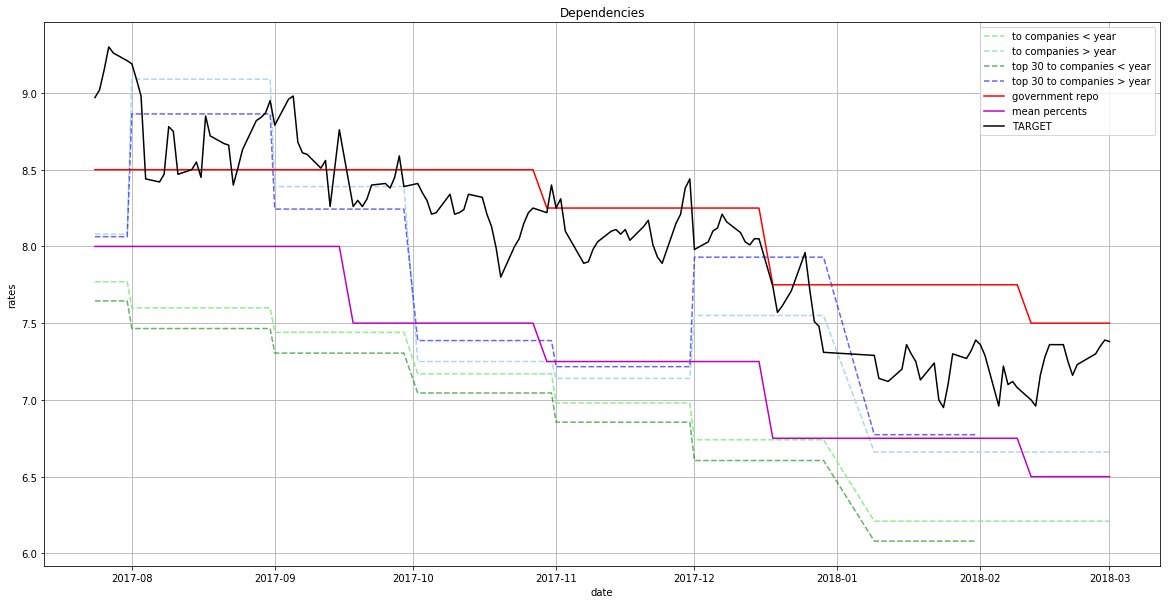

In [109]:
plt.figure(figsize=(20, 10))
plt.title('Dependencies')
plt.plot(sorted(features.index), features['LESS_YEAR_DEPOSITS_TO_COMPANIES_RATES'][sorted(features.index)], label='to companies < year', color='lightgreen', linestyle='--')
plt.plot(sorted(features.index), features['OVER_YEAR_DEPOSITS_TO_COMPANIES_RATES'][sorted(features.index)], label='to companies > year', color='lightblue', linestyle='--')
plt.plot(sorted(features.index), features['MEAN_LESS_YEAR_30'][sorted(features.index)], label='top 30 to companies < year', alpha=0.6, color='green', linestyle='--')
plt.plot(sorted(features.index), features['MEAN_OVER_YEAR_30'][sorted(features.index)], label='top 30 to companies > year', alpha=0.6, color='blue', linestyle='--')
plt.plot(sorted(features.index), features['GOV_REPO_RATE'][sorted(features.index)], label='government repo', color='red')
plt.plot(sorted(features.index), features['MEAN_PERCENTS'][sorted(features.index)], label='mean percents', color='m')
plt.plot(sorted(features.index), target[sorted(features.index)], label='TARGET', color='black')
plt.xlabel('date')
plt.ylabel('rates')
plt.grid()
plt.legend()
plt.savefig('graphs/dep_1')
_ = plt.show()

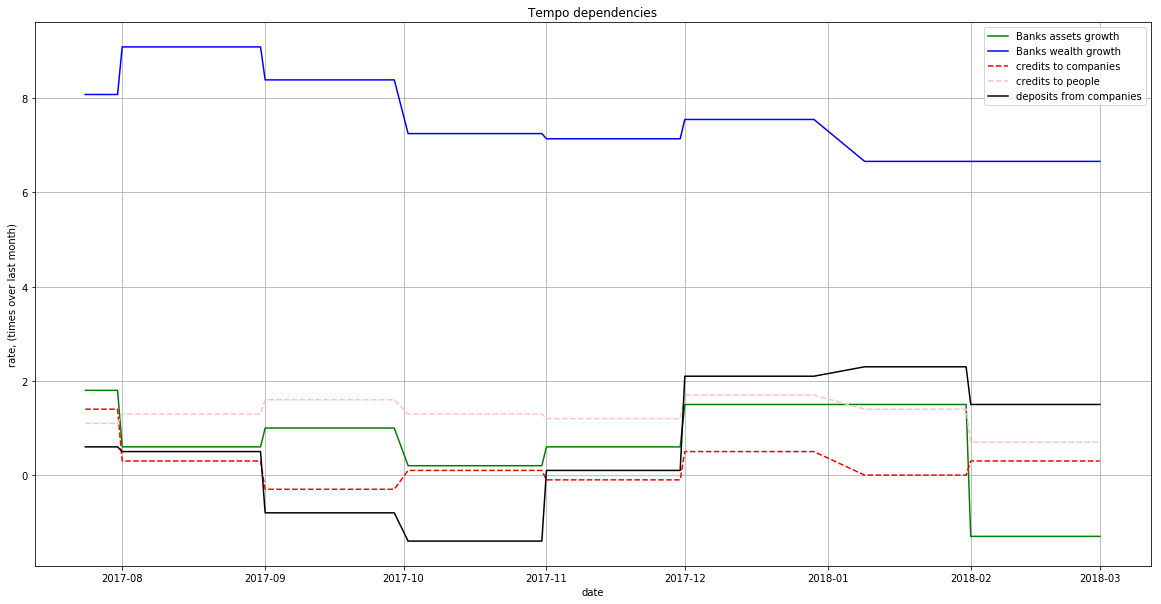

In [107]:
plt.figure(figsize=(20, 10))
plt.title('Tempo dependencies')
plt.ylabel('rate, (times over last month)')
plt.xlabel('date')
plt.plot(sorted(features.index), features['BANK_ASSETS_TEMPO_MONTH'][sorted(features.index)], label='Banks assets growth', color='green', linestyle='-')
plt.plot(sorted(features.index), features['OVER_YEAR_DEPOSITS_TO_COMPANIES_RATES'][sorted(features.index)], label='Banks wealth growth', color='blue', linestyle='-')
plt.plot(sorted(features.index), features['CREDITS_TO_COMPANIES_TEMPO_MONTH'][sorted(features.index)], label='credits to companies', color='red', linestyle='--')
plt.plot(sorted(features.index), features['CREDITS_TO_PEOPLE_TEMPO_MONTH'][sorted(features.index)], label='credits to people', color='pink', linestyle='--')
plt.plot(sorted(features.index), features['DEPOSITS_FROM_COMPANIES_TEMPO_MONTH'][sorted(features.index)], label='deposits from companies', color='black', linestyle='-')
plt.legend()
plt.grid()
plt.savefig('graphs/dep_2')
_ = plt.show()

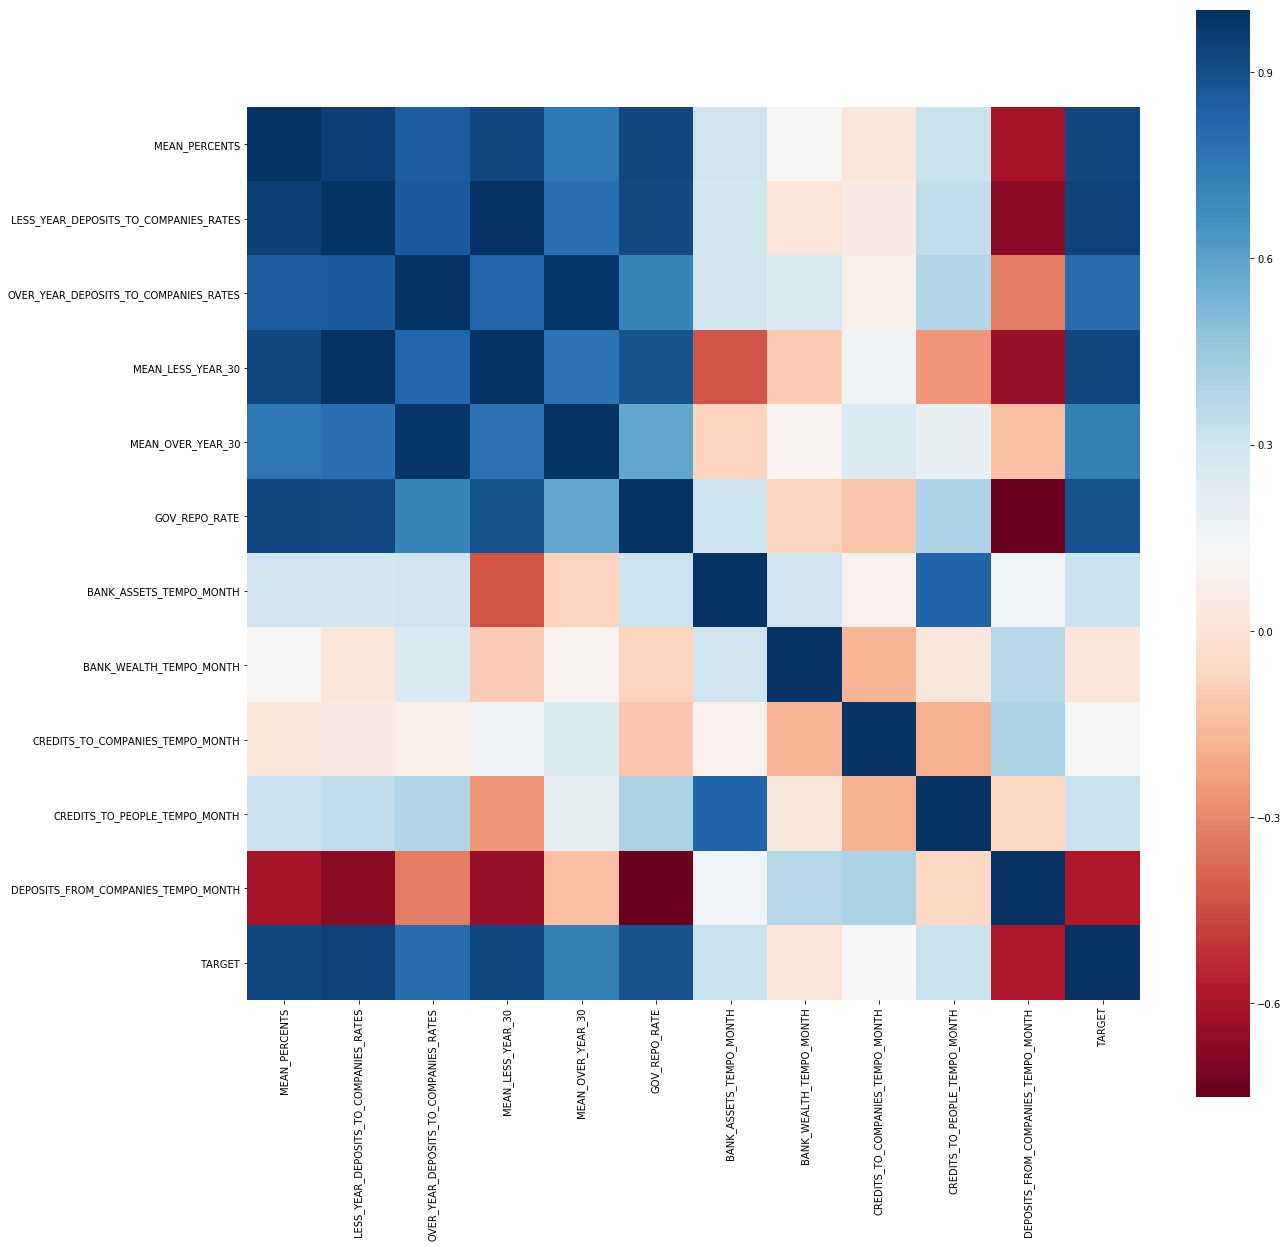

In [245]:
features['TARGET'] = target
fig, ax = plt.subplots(figsize=(20,20))
_ = seaborn.heatmap(features.corr(), square=True, ax=ax, cmap=seaborn.color_palette("RdBu", 200))

In [115]:
main_features = features.copy()

In [118]:
main_features.drop(columns=main_features.columns[-6:], inplace=True)

In [130]:
main_features['MEAN_BANK_RATES'] = main_features.iloc[:, :-1].mean(axis=1)

In [135]:
main_features.drop(columns=main_features.columns[:-2], inplace=True)

In [144]:
sh = pd.concat([main_features, target], axis=1, join='inner')

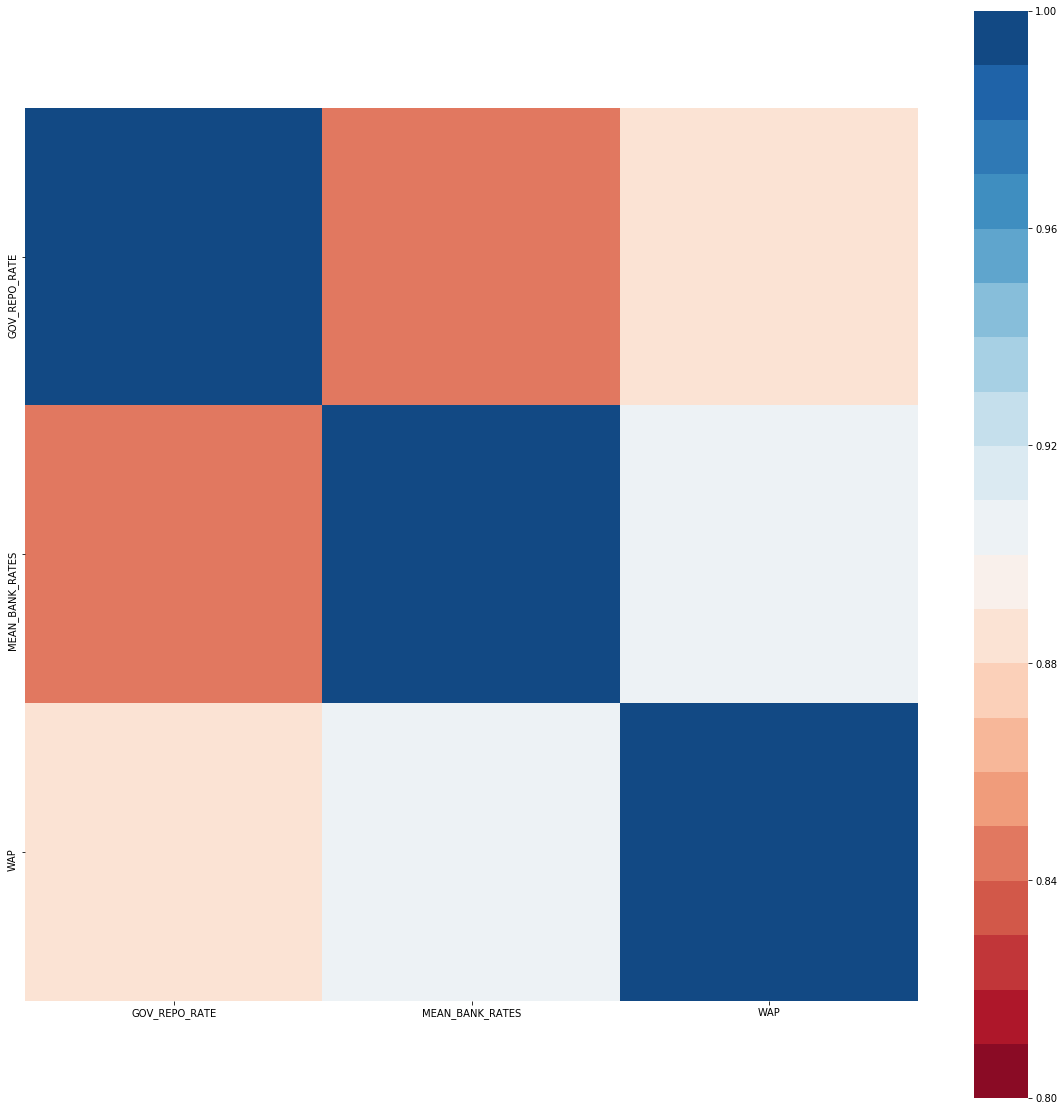

In [251]:
fig, ax = plt.subplots(figsize=(20,20))
_ = seaborn.heatmap(sh.corr(), square=True, ax=ax, vmin=0.8, vmax=1, cmap=seaborn.color_palette("RdBu", 20))

In [166]:
main_features.head()

,GOV_REPO_RATE,MEAN_BANK_RATES
DATE_,,
2017-07-24,8.5,7.911667
2017-07-25,8.5,7.911667
2017-07-26,8.5,7.911667
2017-07-27,8.5,7.911667
2017-07-28,8.5,7.911667


In [167]:
main_features.to_csv('data/main_sec_features.csv')

## Добавим первичные признаки

Сначала выгрузим и обработаем ***индикаторы***. Проблема в том, что файлы разного размера и надо брать различные средние значения.

In [605]:
relations = {0: "Bollinger bands, mean", 
             1: "Accumulation/Distribution", 
             2: "Bollinger bands, lower band", 
             3: "MA Exponential", 
             4: "Envelopes, fist number", 
             5: "Index performance", 
             6: "MA Convergence/Divergence, first number", 
             7: "Momentum", 
             8: "Price Channels, first number", 
             9: "Parabolic SAR"}

In [606]:
ind_base = "indicator"
mean_of = [3, 1, 3, 1, 2, 1, 3, 1, 2, 1]

In [607]:
dfs = []
for i in range(10):
    name = relations[i]
    curr_ind = pd.read_csv('data/primaries/' + ind_base + str(i) + '.csv', names=['DATE', name])
    curr_ind['DATE'] = curr_ind['DATE'].str.lstrip()
    curr_ind['DATE'] = curr_ind['DATE'].str.rstrip()
    curr_ind['DATE'] = pd.to_datetime(curr_ind['DATE'], yearfirst=True)
    curr_ind.sort_values(['DATE', name], inplace=True)
    curr_ind.set_index('DATE', inplace=True)
    mean = curr_ind
    if mean_of[i] > 1:
        mean = curr_ind[0::mean_of[i]]
        for j in range(1, mean_of[i]):
            mean += curr_ind[j::mean_of[i]]
        mean /= mean_of[i]
    dfs.append(mean)

In [613]:
primaries = dfs[0].copy()

In [614]:
for i in range(1, len(dfs)):
    primaries = pd.concat([primaries, dfs[i]], join='outer', axis=1)

In [626]:
primaries = primaries[1:-18]

In [627]:
primaries.fillna(method='ffill', axis=0, inplace=True)
primaries.fillna(method='backfill', axis=0, inplace=True)

/home/sanityseeker/.local/lib/python3.6/site-packages/pandas/core/frame.py:3035: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [599]:
def fix_col_names(features):
    for column in features.columns:
        new_name = column.rstrip().lstrip()
        features.rename({column : new_name}, axis=1, inplace=True)

**Liquidity**

In [518]:
pr_2 = pd.read_csv('data/primaries/liquidity.csv', index_col='DATE')
fix_col_names(pr_2)
pr_2.index = pd.to_datetime(pr_2.index, format='%m/%d/%Y')

In [519]:
pr_2.head()

,CHANGE_MONEY,CHANGE_GOV_REMAINS_BR,MOVING_DEBT,CHANGE_BANKS_DEBT,CHANGE_BANKS_REPO_DEBT,MINFIN_FORCURR_OPERATIONS,BR_REG_RESERVES,BR_NETTO
DATE,,,,,,,,
2018-03-01,-22.2,195.9,0.0,0.0,98.5,15.9,0.0,29.7
2018-02-28,7.5,-329.1,-49.8,-55.9,-198.5,15.7,0.0,-130.4
2018-02-27,34.1,190.0,23.0,0.0,99.8,15.5,0.0,-72.7
2018-02-26,64.5,-708.5,0.0,0.0,-50.1,15.7,0.0,246.1
2018-02-22,-5.3,62.1,-0.8,0.0,150.0,15.7,0.0,-22.5


In [642]:
pr_2.sort_index()

,CHANGE_MONEY,CHANGE_GOV_REMAINS_BR,MOVING_DEBT,CHANGE_BANKS_DEBT,CHANGE_BANKS_REPO_DEBT,MINFIN_FORCURR_OPERATIONS,BR_REG_RESERVES,BR_NETTO
DATE,,,,,,,,
2017-07-24,52.2,-188.2,0.0,0.0,-43.2,0.0,0.0,0.8
2017-07-25,43.9,-519.9,5.5,0.0,70.0,0.0,0.0,77.8
2017-07-26,28.3,76.2,-30.3,0.0,-0.1,0.0,0.0,67.7
2017-07-27,9.0,-48.9,0.0,0.0,-0.1,0.0,0.0,8.6
2017-07-28,7.8,-36.0,0.0,0.0,27.1,0.0,0.0,35.5
2017-07-31,52.6,-153.4,0.0,50.0,-256.5,0.0,0.0,76.2
2017-08-01,18.4,59.6,31.8,0.0,3.1,0.0,0.0,14.6
2017-08-02,-11.1,-50.3,-24.5,-33.3,-60.6,0.0,0.0,-79.0
2017-08-03,-39.8,278.9,0.0,0.0,153.2,0.0,0.0,-44.4


**MosPrimeRate**

In [520]:
pr_3 = pd.read_csv('data/primaries/mosprimerate.csv', index_col='DATE')
fix_col_names(pr_3)
pr_3.index = pd.to_datetime(pr_3.index, format='%m/%d/%Y')

In [521]:
pr_3.head()

,MOSPRIME_ONE_DAY,MOSPRIME_ONE_WEEK,MOSPRIME_TWO_WEEKS,MOSPRIME_ONE_MONTH
DATE,,,,
2018-03-01,7.63,7.63,7.58,7.54
2018-02-28,7.61,7.62,7.56,7.56
2018-02-27,7.56,7.59,7.54,7.53
2018-02-26,7.56,7.58,7.51,7.48
2018-02-22,7.52,7.53,7.48,7.45


In [641]:
pr_3.sort_index()

,MOSPRIME_ONE_DAY,MOSPRIME_ONE_WEEK,MOSPRIME_TWO_WEEKS,MOSPRIME_ONE_MONTH
DATE,,,,
2017-07-24,9.18,9.21,9.19,9.22
2017-07-25,9.17,9.19,9.19,9.22
2017-07-26,9.21,9.21,9.19,9.22
2017-07-27,9.26,9.23,9.21,9.22
2017-07-28,9.31,9.24,9.22,9.22
2017-07-31,9.33,9.28,9.25,9.24
2017-08-01,9.29,9.3,9.29,9.26
2017-08-02,9.22,9.23,9.24,9.26
2017-08-03,9.15,9.19,9.24,9.26


**MosRepoKSU_day**

In [522]:
pr_41 = pd.read_csv('data/primaries/mosrepoksu12.csv', names=['DATE', '12'], index_col='DATE')
fix_col_names(pr_41)
pr_41.index = pd.to_datetime(pr_41.index, format='%m/%d/%Y')
pr_42 = pd.read_csv('data/primaries/mosrepoksu19.csv', names=['DATE', '19'], index_col='DATE')
fix_col_names(pr_42)
pr_42.index = pd.to_datetime(pr_42.index, format='%m/%d/%Y')
pr_4 = pd.concat([pr_41, pr_42], axis=1, join='inner')
pr_4['MEAN_REPO_KSU_DAY'] = pr_4.iloc[:, :].mean(axis=1)
pr_4.drop(columns=pr_4.columns[:-1], inplace=True)

In [525]:
pr_4.head()

,MEAN_REPO_KSU_DAY
DATE,
2018-03-01,7.375
2018-02-28,7.410
2018-02-27,7.350
2018-02-26,7.310
2018-02-22,7.230


In [640]:
pr_4.sort_index()

,MEAN_REPO_KSU_DAY
DATE,
2017-08-01,9.130
2017-08-02,9.080
2017-08-03,8.950
2017-08-04,8.325
2017-08-07,8.170
2017-08-08,8.355
2017-08-09,8.855
2017-08-10,8.770
2017-08-11,8.490


**MosRepoKSU_week**

In [526]:
pr_51 = pd.read_csv('data/primaries/mosrepoksu121week.csv', names=['DATE', '12'], index_col='DATE')
fix_col_names(pr_51)
pr_51.index = pd.to_datetime(pr_51.index, format='%m/%d/%Y')
pr_52 = pd.read_csv('data/primaries/mosrepoksu191week.csv', names=['DATE', '19'], index_col='DATE')
fix_col_names(pr_52)
pr_52.index = pd.to_datetime(pr_52.index, format='%m/%d/%Y')
pr_5 = pd.concat([pr_51, pr_52], axis=1, join='inner')
pr_5['MEAN_REPO_KSU_WEEK'] = pr_5.iloc[:, :].mean(axis=1)
pr_5.drop(columns=pr_5.columns[:-1], inplace=True)

In [639]:
pr_5.sort_index()

,MEAN_REPO_KSU_WEEK
DATE,
2017-08-01,9.175
2017-08-02,9.110
2017-08-03,9.055
2017-08-04,8.955
2017-08-07,8.580
2017-08-08,8.795
2017-08-09,4.490
2017-08-10,8.900
2017-08-11,8.825


In [638]:
pr_5.shape

(148, 1)

**ROISfix**

In [528]:
pr_6 = pd.read_csv('data/primaries/rosfix.csv', index_col='DATE')
fix_col_names(pr_6)
pr_6.index = pd.to_datetime(pr_6.index, format='%m/%d/%Y')

In [531]:
pr_6.head()

,ROISFIX_ONE_WEEK,ROISFIX_TWO_WEEKS,ROISFIX_ONE_MONTH
DATE,,,
2017-07-24,8.94,8.94,8.93
2017-07-25,8.94,8.94,8.93
2017-07-26,8.94,8.94,8.93
2017-07-27,8.94,8.94,8.93
2017-07-28,8.94,8.94,8.93


In [637]:
pr_6.shape

(151, 3)

**RTSI**

In [532]:
pr_7 = pd.read_csv('data/primaries/rtsi.csv', index_col='DATE')
fix_col_names(pr_7)
pr_7['MEAN_RTSI'] = pr_7.iloc[:, :].mean(axis=1)
pr_7.index = pd.to_datetime(pr_7.index, format='%m/%d/%Y')
pr_7.drop(columns=pr_7.columns[:-1], inplace=True)

In [533]:
pr_7.head()

,MEAN_RTSI
DATE,
2018-03-01,1275.6675
2018-02-28,1297.1400
2018-02-27,1321.7600
2018-02-26,1321.8375
2018-02-22,1291.8650


In [557]:
pr_7.shape

(154, 1)

**RUONIA**

In [571]:
pr_8 = pd.read_csv('data/primaries/ruonia.csv', names=['DATE', 'RUONIA', '1'], index_col='DATE')
fix_col_names(pr_8)
pr_8.index = pd.to_datetime(pr_8.index, format='%m/%d/%Y', infer_datetime_format=True)
pr_8.drop(columns=pr_8.columns[-1], inplace=True)

In [572]:
pr_8.head()

,RUONIA
DATE,
2018-01-03,7.38
2018-02-28,7.50
2018-02-27,7.45
2018-02-26,7.30
2018-02-22,7.23


In [636]:
pr_8.shape

(150, 1)

**RUREPO**

In [538]:
pr_9 = pd.read_csv('data/primaries/rurepo.csv', names=['DATE', 'RUREPO_ON', 'RUREPO_WEEK','RUREPO_TWO_WEEKS', 'RUREPO_MONTH'], index_col='DATE')
fix_col_names(pr_9)
pr_9.index = pd.to_datetime(pr_9.index, format='%m/%d/%Y')

In [539]:
pr_9.head()

,RUREPO_ON,RUREPO_WEEK,RUREPO_TWO_WEEKS,RUREPO_MONTH
DATE,,,,
2017-07-24,9.55,9.63,9.68,9.78
2017-07-25,9.52,9.61,9.68,9.78
2017-07-26,9.59,9.68,9.75,9.86
2017-07-27,9.58,9.65,9.73,9.83
2017-07-28,9.55,9.63,9.70,9.79


In [635]:
pr_9.shape

(151, 4)

**SALDO**

In [574]:
pr_0 = pd.read_csv('data/primaries/saldo.csv', names=['DATE', 'SALDO'], index_col='DATE')
fix_col_names(pr_0)
pr_0.index = pd.to_datetime(pr_0.index, format='%d.%m.%Y')

In [575]:
pr_0.head()

,SALDO
DATE,
2018-03-01,158.1
2018-02-28,291.9
2018-02-27,84.0
2018-02-26,329.4
2018-02-22,114.8


In [576]:
pr_0.shape

(151, 1)

In [643]:
pr = pd.concat([primaries, pr_0, pr_2, pr_3, pr_4, pr_5, pr_6, pr_7, pr_8, pr_9], join='outer', axis=1)

In [647]:
pr.shape

(184, 34)

In [645]:
pr.fillna(method='ffill', axis=0, inplace=True)
pr.fillna(method='backfill', axis=0, inplace=True)

In [648]:
pr.to_csv('data/primaries.csv')

### Объединим данные

In [1139]:
original = pd.read_csv('data/trade_data.csv', index_col='DATE')
original.drop('LTTIME', axis=1, inplace=True)
original['MEAN_PARAMS'] = original.iloc[:,:4].mean(axis=1)
original.index = pd.to_datetime(original.index, dayfirst=True)
original.drop(columns=original.columns[:4], inplace=True, axis=1)

In [1140]:
pr = pd.read_csv('data/primaries.csv', index_col='DATE')
pr.index = pd.to_datetime(pr.index, yearfirst=True)

In [1141]:
sec = pd.read_csv('data/main_sec_features.csv', index_col='DATE_')
sec.index = pd.to_datetime(sec.index, yearfirst=True)

In [1142]:
final_df = pd.concat([pr, sec, original], join='inner', axis=1)

In [1143]:
final_df.head()

,"Bollinger bands, mean",Accumulation/Distribution,"Bollinger bands, lower band",MA Exponential,"Envelopes, fist number",Index performance,"MA Convergence/Divergence, first number",Momentum,"Price Channels, first number",Parabolic SAR,...,RUREPO_ON,RUREPO_WEEK,RUREPO_TWO_WEEKS,RUREPO_MONTH,GOV_REPO_RATE,MEAN_BANK_RATES,WAP,VALUE,NUMTRADES,MEAN_PARAMS
2017-07-24,8.5585,-4.744700e+09,8.5585,8.98444,8.5585,-2.752470,-0.002859,-0.15,8.475,8.50000,...,9.55,9.63,9.68,9.78,8.5,7.911667,8.97,2325011000,37,8.8275
2017-07-25,8.5585,-8.602970e+09,8.5585,8.98444,8.5585,0.182460,-0.002859,-0.15,8.475,8.51200,...,9.52,9.61,9.68,9.78,8.5,7.911667,9.02,3477388000,31,8.9525
2017-07-26,8.5585,-9.634070e+09,8.5585,8.98444,8.5585,0.350758,-0.002859,-0.15,8.475,8.54552,...,9.59,9.68,9.75,9.86,8.5,7.911667,9.15,6537394000,36,9.1400
2017-07-27,8.5585,-1.429350e+10,8.5585,8.98444,8.5585,0.058554,-0.002859,-0.15,8.475,8.59679,...,9.58,9.65,9.73,9.83,8.5,7.911667,9.30,3387899000,26,9.2475
2017-07-28,8.5585,-1.429350e+10,8.5585,8.98444,8.5585,0.058554,-0.002859,-0.15,8.475,8.59679,...,9.55,9.63,9.70,9.79,8.5,7.911667,9.26,4659405000,31,9.2575


In [1144]:
final_df.to_csv('data/all_features.csv')

## Еще немного графиков

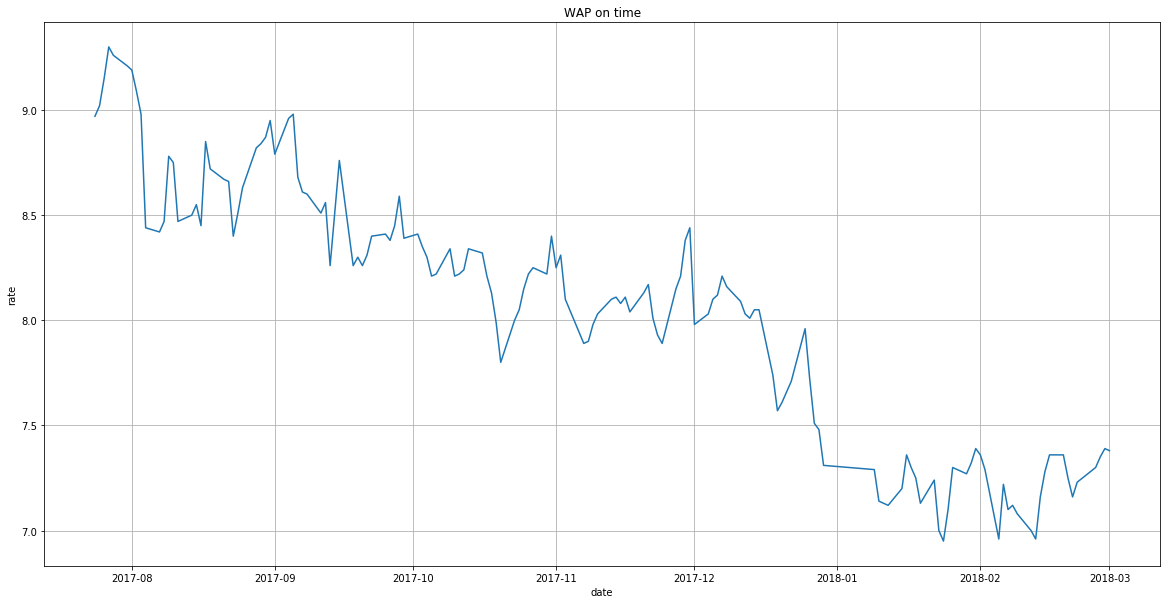

In [984]:
plt.figure(figsize=(20, 10))
plt.title('WAP on time')
plt.xlabel('date')
plt.ylabel('rate')
plt.plot(target)
plt.grid()
plt.show()

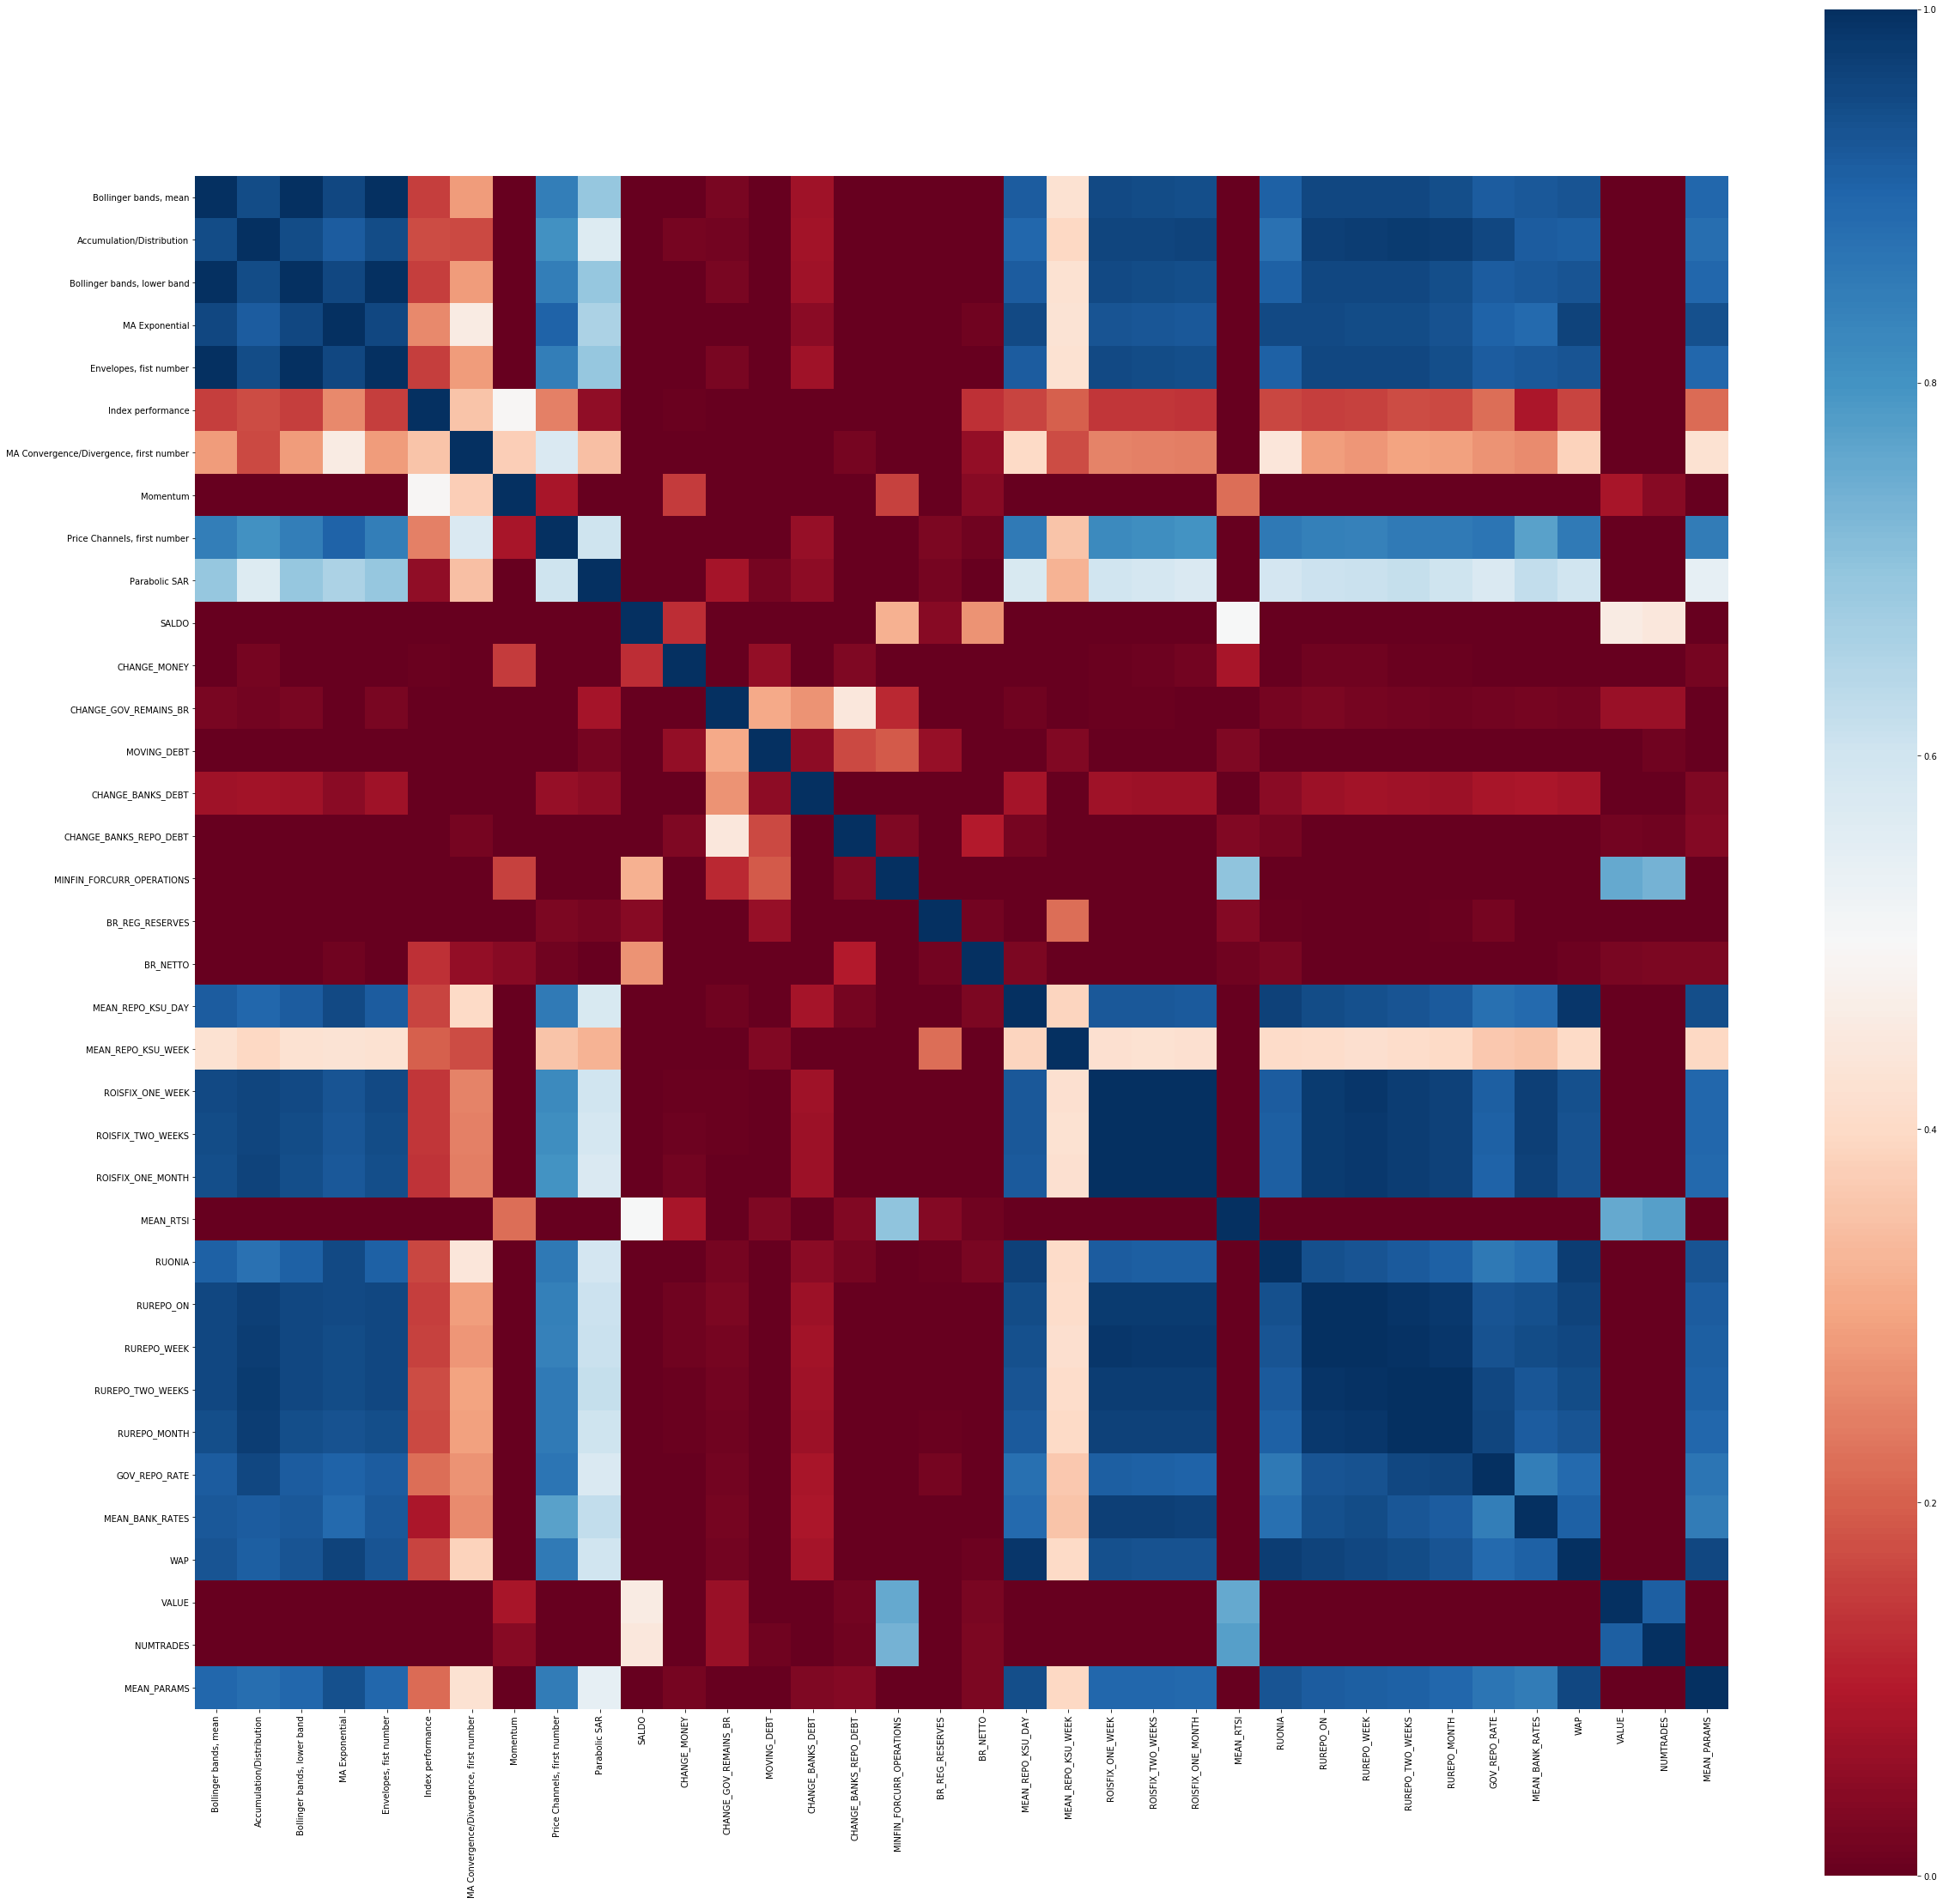

In [985]:
fig, ax = plt.subplots(figsize=(40,40))
_ = seaborn.heatmap(final_df.corr(), square=True, ax=ax, vmin=0, vmax=1, cmap=seaborn.color_palette("RdBu", 300))

In [986]:
CHOSEN_FEATURES = ['MEAN_PARAMS', 'MEAN_BANK_RATES', 'GOV_REPO_RATE', 'RUREPO_MONTH', 'RUREPO_TWO_WEEKS',
                   'RUREPO_WEEK', 'RUREPO_ON', 'RUONA', 'ROSFIX_ONE_MONTH', 'ROSFIX_TWO_WEEKS', 'ROSFIX_ONE_WEEK',
                  'MEAN_REPO_KSU_DAY', 'Price Channels, first number', 'Envelopes, fist number', 'MA Exponential',
                  'Bollinger bands, lower band', 'Accumulation/Distribution', 'Bollinger bands, mean']

## Модели

In [1145]:
target = final_df['WAP']
final_df.drop('WAP', axis=1, inplace=True)

In [1146]:
final_df = final_df.astype(float)

In [1147]:
final_df['DAY'] = final_df.index.day
final_df['MONTH'] = final_df.index.month
final_df['weekday'] = final_df.index.weekday

In [1148]:
target_diff = target - target.shift(1)

In [1149]:
banary_y = np.zeros_like(target_diff[1:])
binary_y = target_diff[1:] >= 0
binary_y.astype(int)
binary_y[binary_y < 1] -= 1

In [1150]:
changed_data = final_df[1:].copy()

In [1151]:
X_train = changed_data[:-20]
X_test = changed_data[-20:]
y_train = binary_y[:-20]
y_test = binary_y[-20:]

In [1152]:
from sklearn import cross_validation, metrics
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV

In [1153]:
clf = xgb.XGBClassifier(silent=False, nthread=4, max_depth=3, n_estimators=1200, subsample=0.5, learning_rate=0.03, seed=1)

In [1154]:
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.03, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1200,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=1, silent=False,
       subsample=0.5)

In [1155]:
preds = clf.predict(X_test)

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [1156]:
metrics.f1_score(y_test, preds, average='macro')

0.7333333333333334

In [1157]:
f1_scorer = metrics.make_scorer(metrics.f1_score, average='macro')

In [1158]:
param_test = {
    'n_estimators': np.arange(600, 1200, 100) 
}
gsearch = GridSearchCV(clf, param_grid=param_test, scoring=f1_scorer, iid=False)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_, gsearch.best_score_)
clf.set_params(n_estimators=gsearch.best_params_['n_estimators'])

param_test = {
 'max_depth':range(3, 8),
 'min_child_weight':range(2, 8)
}
gsearch = GridSearchCV(clf, param_grid=param_test, scoring=f1_scorer, iid=False)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_, gsearch.best_score_)
clf.set_params(max_depth=gsearch.best_params_['max_depth'], 
               min_child_weight=gsearch.best_params_['min_child_weight'])

test_gamma = { 'gamma' : np.arange(0, 0.5, 0.1)}
gsearch = GridSearchCV(clf, param_grid=test_gamma, scoring=f1_scorer, iid=False, cv=3)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_, gsearch.best_score_)

clf.set_params(gamma=gsearch.best_params_['gamma'])

param_test = {
 'subsample': np.arange(0.2, 0.8, 0.1),
 'colsample_bytree': np.arange(0.3, 0.9, 0.1)
}
gsearch = GridSearchCV(clf, param_grid=param_test, scoring=f1_scorer, iid=False, cv=3)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_, gsearch.best_score_)

clf.set_params(colsample_bytree=gsearch.best_params_['colsample_bytree'])
clf.set_params(subsample=gsearch.best_params_['subsample'])

param_test = {
 'reg_alpha': [0.05, 0.01, 0.03, 0.1, 0.2, 0.3, 0.4, 0.5],
}
gsearch = GridSearchCV(clf, param_grid=param_test, scoring=f1_scorer, iid=False, cv=3)
gsearch.fit(X_train, y_train)
print(gsearch.best_params_, gsearch.best_score_)
clf.set_params(reg_alpha=gsearch.best_params_['reg_alpha'])


/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

{'n_estimators': 1100} 0.41379938053268717


/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

{'max_depth': 3, 'min_child_weight': 5} 0.5327007723756927


/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

{'gamma': 0.0} 0.5327007723756927


/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-def

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

{'colsample_bytree': 0.9000000000000001, 'subsample': 0.5000000000000001} 0.5348746837490034


/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empt

{'reg_alpha': 0.4} 0.5477561327561328


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9000000000000001, gamma=0.0, learning_rate=0.03,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=1100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=False, subsample=0.5000000000000001)

In [1159]:
clf

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9000000000000001, gamma=0.0, learning_rate=0.03,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=1100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=False, subsample=0.5000000000000001)

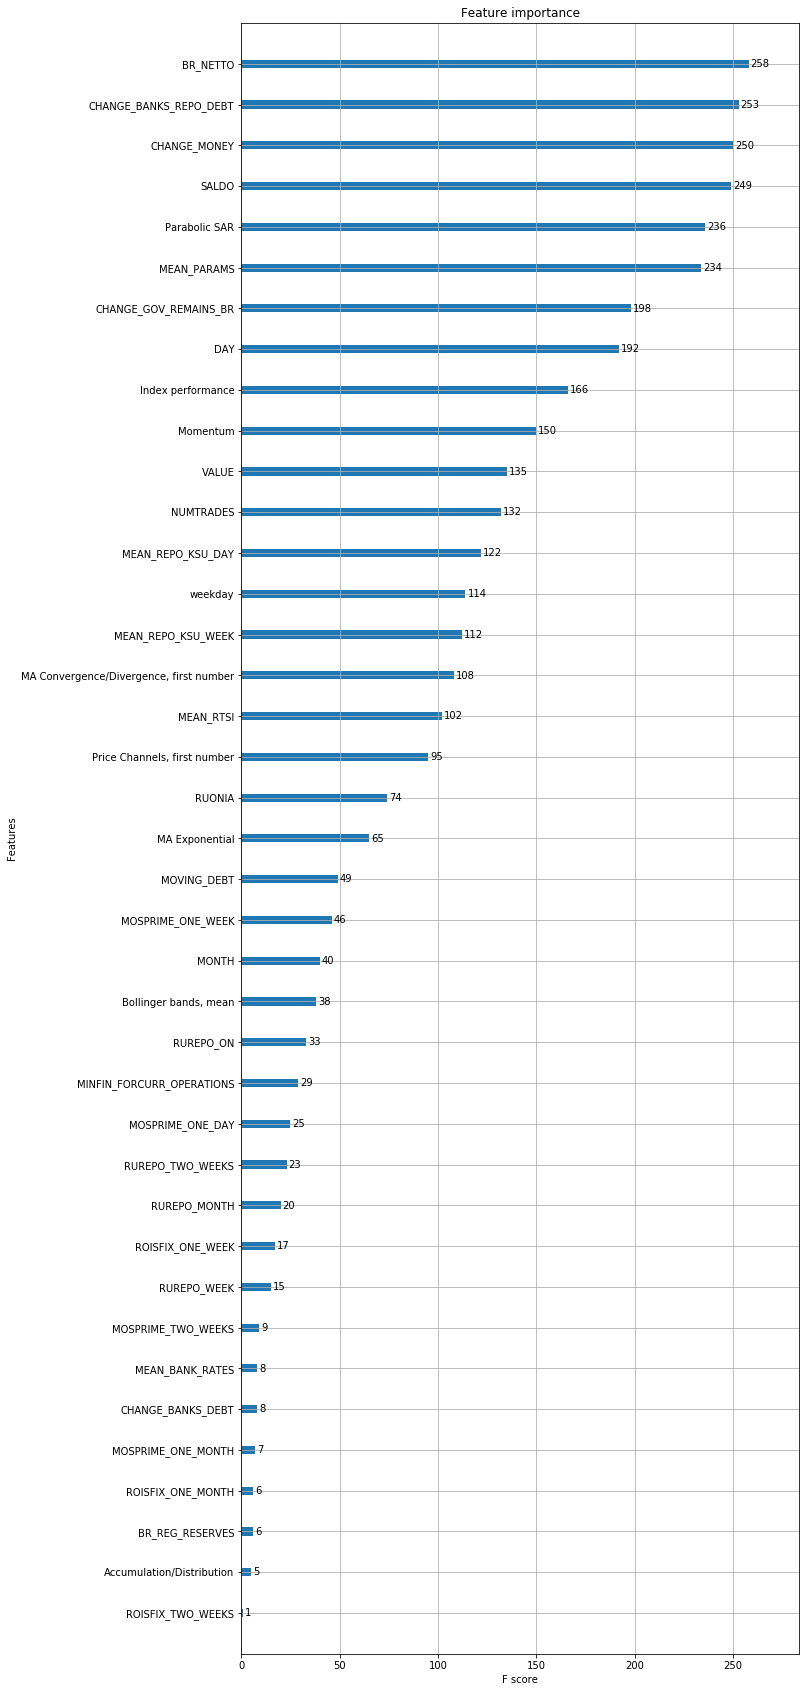

In [1160]:
fig, ax = plt.subplots(figsize=(10, 30))
xgb.plot_importance(clf, ax=ax)

In [1161]:
features_num = 18

In [1162]:
imps = np.array(clf.feature_importances_)
features = np.arange(len(imps))
sorted_features = [x for _, x in sorted(zip(imps, features), key=lambda pair: pair[0])]
sorted_features = sorted_features[::-1]
best_features = sorted_features[:features_num]
best_columns = np.array(X_train.columns)[best_features]

In [1163]:
best_columns

array(['BR_NETTO', 'CHANGE_BANKS_REPO_DEBT', 'CHANGE_MONEY', 'SALDO',
       'Parabolic SAR', 'MEAN_PARAMS', 'CHANGE_GOV_REMAINS_BR', 'DAY',
       'Index performance', 'Momentum', 'VALUE', 'NUMTRADES',
       'MEAN_REPO_KSU_DAY', 'weekday', 'MEAN_REPO_KSU_WEEK',
       'MA Convergence/Divergence, first number', 'MEAN_RTSI',
       'Price Channels, first number'], dtype=object)

In [1164]:
dataframe = pd.DataFrame()
for i in [1, 2, 4]:
    for feature in best_columns:
        series = final_df[feature]
        dataframe[feature + str(i)] = series.shift(i)
        dataframe['WAP' + str(i)] = target.shift(i)
        
for feature in best_columns:
    series = final_df[feature]
    dataframe[feature] = series.values

In [1165]:
dataframe.dropna(inplace=True)

In [1166]:
dataframe.head()

,BR_NETTO1,WAP1,CHANGE_BANKS_REPO_DEBT1,CHANGE_MONEY1,SALDO1,Parabolic SAR1,MEAN_PARAMS1,CHANGE_GOV_REMAINS_BR1,DAY1,Index performance1,...,Index performance,Momentum,VALUE,NUMTRADES,MEAN_REPO_KSU_DAY,weekday,MEAN_REPO_KSU_WEEK,"MA Convergence/Divergence, first number",MEAN_RTSI,"Price Channels, first number"
2017-07-28,8.6,9.30,-0.1,9.0,-116.0,8.59679,9.2475,-48.9,27.0,0.058554,...,0.058554,-0.15,4.659405e+09,31.0,9.13,4,9.175,-0.002859,1019.2650,8.475
2017-07-31,35.5,9.26,27.1,7.8,-123.7,8.59679,9.2575,-36.0,28.0,0.058554,...,-1.776890,-0.15,5.181650e+09,26.0,9.13,0,9.175,-0.002859,1008.6250,8.475
2017-08-01,76.2,9.21,-256.5,52.6,-158.5,8.69028,9.2025,-153.4,31.0,-1.776890,...,-2.242520,-0.15,4.002500e+09,30.0,9.13,1,9.175,-0.002859,1016.0250,8.475
2017-08-02,14.6,9.19,3.1,18.4,-234.3,8.73287,9.1925,59.6,1.0,-2.242520,...,-4.957360,-0.15,5.745400e+09,27.0,9.08,2,9.110,-0.002859,1017.0675,8.475
2017-08-03,-79.0,9.09,-60.6,-11.1,-361.9,9.40000,9.0950,-50.3,2.0,-4.957360,...,-16.646100,-0.15,5.598335e+09,52.0,8.95,3,9.055,-0.002859,1024.9425,8.475


In [1167]:
with_lagged = pd.concat([dataframe, target], axis=1, join='inner')

In [1168]:
with_lagged.head()

,BR_NETTO1,WAP1,CHANGE_BANKS_REPO_DEBT1,CHANGE_MONEY1,SALDO1,Parabolic SAR1,MEAN_PARAMS1,CHANGE_GOV_REMAINS_BR1,DAY1,Index performance1,...,Momentum,VALUE,NUMTRADES,MEAN_REPO_KSU_DAY,weekday,MEAN_REPO_KSU_WEEK,"MA Convergence/Divergence, first number",MEAN_RTSI,"Price Channels, first number",WAP
2017-07-28,8.6,9.30,-0.1,9.0,-116.0,8.59679,9.2475,-48.9,27.0,0.058554,...,-0.15,4.659405e+09,31.0,9.13,4,9.175,-0.002859,1019.2650,8.475,9.26
2017-07-31,35.5,9.26,27.1,7.8,-123.7,8.59679,9.2575,-36.0,28.0,0.058554,...,-0.15,5.181650e+09,26.0,9.13,0,9.175,-0.002859,1008.6250,8.475,9.21
2017-08-01,76.2,9.21,-256.5,52.6,-158.5,8.69028,9.2025,-153.4,31.0,-1.776890,...,-0.15,4.002500e+09,30.0,9.13,1,9.175,-0.002859,1016.0250,8.475,9.19
2017-08-02,14.6,9.19,3.1,18.4,-234.3,8.73287,9.1925,59.6,1.0,-2.242520,...,-0.15,5.745400e+09,27.0,9.08,2,9.110,-0.002859,1017.0675,8.475,9.09
2017-08-03,-79.0,9.09,-60.6,-11.1,-361.9,9.40000,9.0950,-50.3,2.0,-4.957360,...,-0.15,5.598335e+09,52.0,8.95,3,9.055,-0.002859,1024.9425,8.475,8.98


In [1169]:
lagged_target = with_lagged.WAP
with_lagged.drop('WAP', axis=1, inplace=True)

In [1181]:
lagged_target_diff = lagged_target - lagged_target.shift(1)
binary_y = lagged_target_diff[1:] >= 0
binary_y.astype(int)
binary_y[binary_y < 1] -= 1

In [1182]:
with_lagged = with_lagged[1:]

In [1183]:
lagged_X_train = with_lagged[:-20]
lagged_X_test = with_lagged[-20:]
lagged_y_train = binary_y[:-20]
lagged_y_test = binary_y[-20:]

In [1173]:
clf.fit(lagged_X_train, lagged_y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.9000000000000001, gamma=0.0, learning_rate=0.03,
       max_delta_step=0, max_depth=3, min_child_weight=5, missing=None,
       n_estimators=1100, n_jobs=1, nthread=4, objective='binary:logistic',
       random_state=0, reg_alpha=0.4, reg_lambda=1, scale_pos_weight=1,
       seed=1, silent=False, subsample=0.5000000000000001)

/home/sanityseeker/.local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


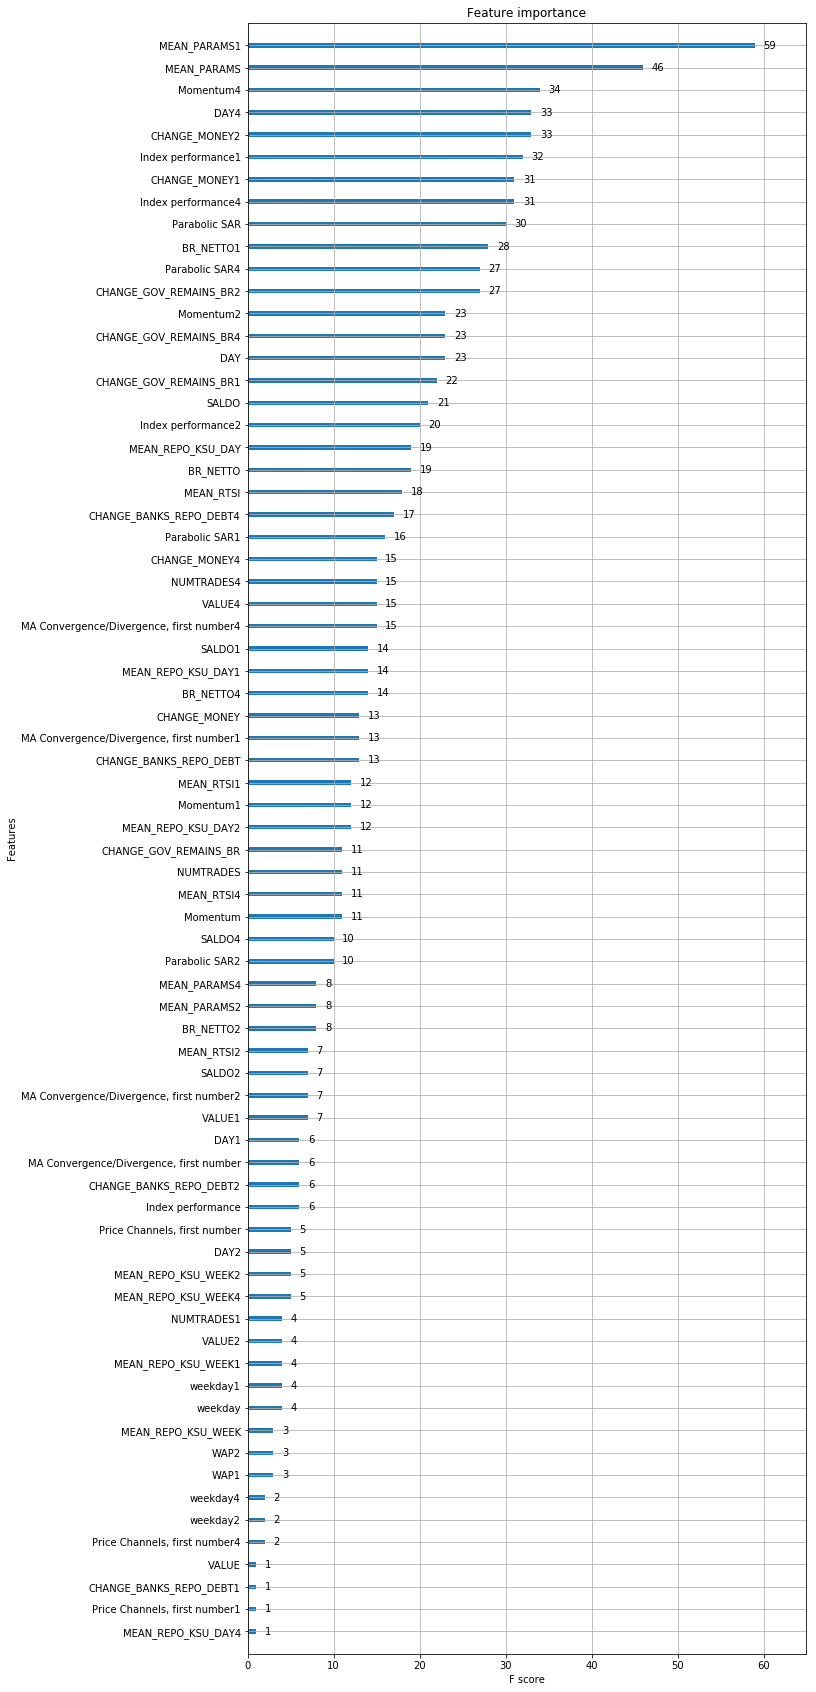

In [1174]:
lagged_preds = clf.predict(lagged_X_test)
fig, ax = plt.subplots(figsize=(10, 30))
xgb.plot_importance(clf, ax=ax)

In [1175]:
metrics.f1_score(lagged_y_test, lagged_preds, average='macro')

0.7442455242966751

In [1089]:
lagged_target = lagged_target[1:]

Регрессор

In [1090]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

In [1091]:
reg = GradientBoostingRegressor()

In [1093]:
lagged_real_target_train = lagged_target[1:-20]

In [1099]:
lagged_real_target_test = lagged_target[-19:]

In [1102]:
lagged_X_train = lagged_X_train[:-1]

In [1103]:
lagged_real_target_train.head()

2017-08-01    9.19
2017-08-02    9.09
2017-08-03    8.98
2017-08-04    8.44
2017-08-07    8.42
Name: WAP, dtype: float64

In [1104]:
reg.fit(lagged_X_train, lagged_real_target_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [1107]:
real_preds = reg.predict(lagged_X_test[:-1])

In [1108]:
mean_squared_error(lagged_real_target_test, real_preds)**0.5

0.13803051598458604

In [1109]:
print(real_preds)
print(lagged_real_target_test.values)

[7.29332735 7.26442967 7.24371862 7.2144309  7.24031681 7.25715428
 7.24986224 7.25835862 7.25595057 7.27496737 7.29011696 7.2919169
 7.30619498 7.16510462 7.17704997 7.19811753 7.23996507 7.31543103
 7.30546759]
[7.29 6.96 7.22 7.1  7.12 7.08 7.   6.96 7.16 7.28 7.36 7.36 7.25 7.16
 7.23 7.3  7.35 7.39 7.38]


In [1176]:
features_num = 18

In [1177]:
imps = np.array(clf.feature_importances_)
features = np.arange(len(imps))
sorted_features = [x for _, x in sorted(zip(imps, features), key=lambda pair: pair[0])]
sorted_features = sorted_features[::-1]
best_features = sorted_features[:features_num]
best_columns = np.array(lagged_X_train.columns)[best_features]

In [1178]:
best_columns

array(['MEAN_PARAMS1', 'MEAN_PARAMS', 'Momentum4', 'DAY4',
       'CHANGE_MONEY2', 'Index performance1', 'Index performance4',
       'CHANGE_MONEY1', 'Parabolic SAR', 'BR_NETTO1', 'Parabolic SAR4',
       'CHANGE_GOV_REMAINS_BR2', 'DAY', 'CHANGE_GOV_REMAINS_BR4',
       'Momentum2', 'CHANGE_GOV_REMAINS_BR1', 'SALDO',
       'Index performance2'], dtype=object)

## А на будущее данных-то не завезли.. Prophet сейчас все сломает :(

In [1180]:
import fbprophet as prophet

In [1236]:
best_columns

array(['MEAN_PARAMS1', 'MEAN_PARAMS', 'Momentum4', 'DAY4',
       'CHANGE_MONEY2', 'Index performance1', 'Index performance4',
       'CHANGE_MONEY1', 'Parabolic SAR', 'BR_NETTO1', 'Parabolic SAR4',
       'CHANGE_GOV_REMAINS_BR2', 'DAY', 'CHANGE_GOV_REMAINS_BR4',
       'Momentum2', 'CHANGE_GOV_REMAINS_BR1', 'SALDO',
       'Index performance2'], dtype=object)

Лаговые фичи надо вынести

In [1247]:
prophets = {}
for feature in best_columns[:1]:
    timeseries = pd.DataFrame()
    timeseries['ds'] = with_lagged.index
    timeseries.set_index(timeseries['ds'], inplace=True)
    timeseries['y'] = with_lagged[feature]
    if np.all(timeseries['y'] > 0):
        timeseries['y'] = np.log(timeseries['y'])
#     print(with_lagged[feature])
    m = prophet.Prophet(weekly_seasonality=False)
    timeseries.index = np.arange(len(timeseries.index))
#     print(timeseries)

    m.fit(timeseries[:-30])

    prophets[feature] = m

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/home/sanityseeker/.local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [1248]:
new_data = with_lagged[best_columns].copy()
new_data['ds'] = new_data.index

In [1267]:
for feature in best_columns[:1]:
    new_data['prophet' + feature] = prophets[feature].predict(new_data[['ds']])['yhat']
    print(new_data)
    if np.all(with_lagged[feature] > 0):
        new_data['prophet' + feature] = np.exp(new_data['prophet' + feature])
        print(new_data['prophet' + feature])

            MEAN_PARAMS1  MEAN_PARAMS  Momentum4  DAY4  CHANGE_MONEY2  \
2017-08-01        9.2025       9.1925      -0.15  26.0            7.8   
2017-08-02        9.1925       9.0950      -0.15  27.0           52.6   
2017-08-03        9.0950       8.8650      -0.15  28.0           18.4   
2017-08-04        8.8650       8.2650      -0.15  31.0          -11.1   
2017-08-07        8.2650       8.3900      -0.15   1.0          -39.8   
2017-08-08        8.3900       8.4250      -0.15   2.0          -37.9   
2017-08-09        8.4250       8.6925      -0.15   3.0           16.4   
2017-08-10        8.6925       8.5100      -0.15   4.0           -2.4   
2017-08-11        8.5100       8.6725      -0.15   7.0          -16.3   
2017-08-14        8.6725       8.6950      -0.15   8.0          -40.6   
2017-08-15        8.6950       8.5775      -0.61   9.0          -43.7   
2017-08-16        8.5775       8.1750      -0.45  10.0            9.0   
2017-08-17        8.1750       8.6300      -0.45  1

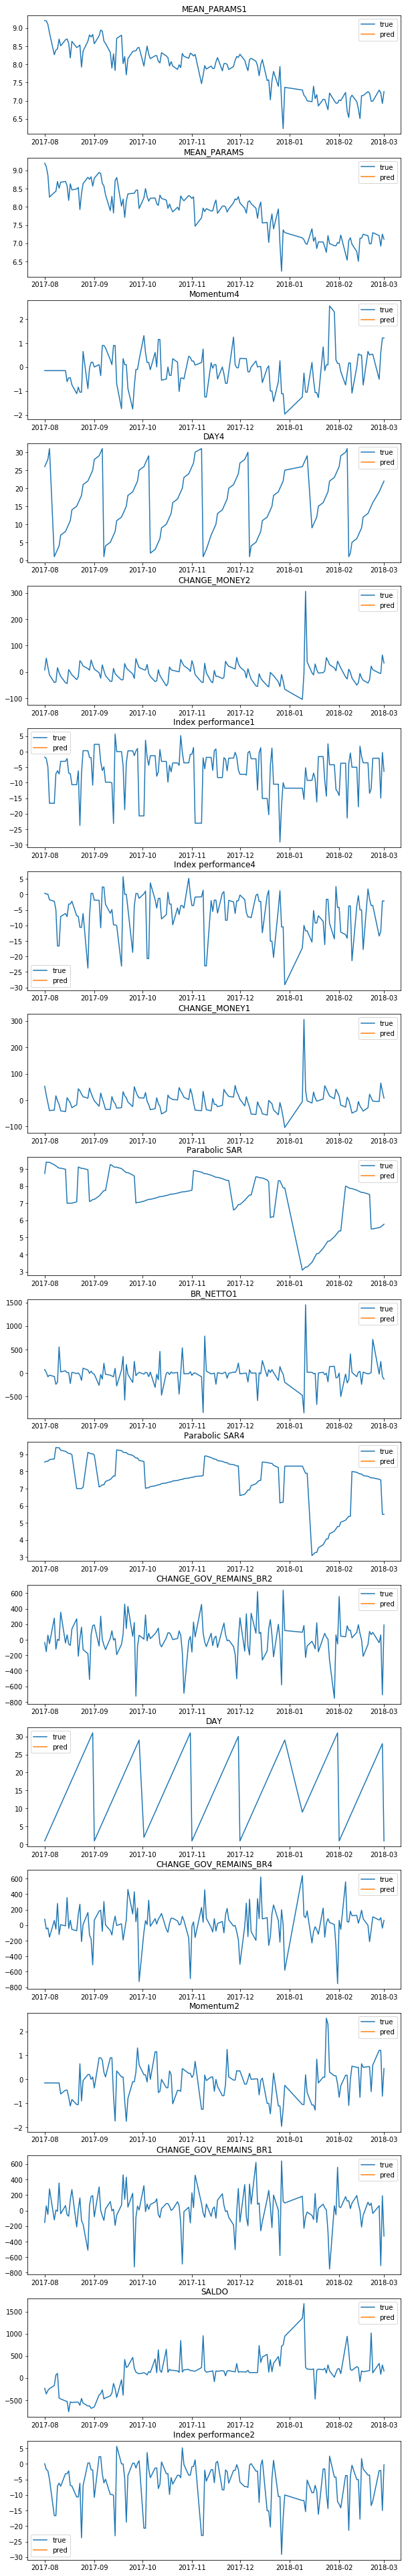

In [1233]:
fig, ax = plt.subplots(len(best_columns), figsize=(10, 70))
for i, feature in enumerate(best_columns):
    ax[i].plot(with_lagged[feature], label='true')
    ax[i].plot(new_data['prophet' + feature], label='pred')
    ax[i].legend()
    ax[i].set_title(feature)